# BMap + kNN


In [1]:
%matplotlib inline
import math
import os
import data_util
import BMapModel
#from data_util import DataPoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import faiss
import util
# import joblib # version incompatibel with sklearn's joblib and can't load the previous model


from sklearn.externals import joblib # store classifiers
from sklearn.preprocessing import MultiLabelBinarizer # convert y to {0,1}^L
from sklearn.preprocessing import StandardScaler # normalize features 
from sklearn.feature_extraction import DictVectorizer # extract feature vector to x
from numpy.random import normal # generate transforming matrix
from sklearn.neighbors import KDTree #KDTree for fast kNN search
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import average_precision_score
from joblib import Parallel, delayed # Multitread
from pytictoc import TicToc

Failed to load GPU Faiss: No module named swigfaiss_gpu
Faiss falling back to CPU-only.


In [2]:
!ls -R ../data

../data:
AmazonCat  Delicious  Mediamill  README_Datasets  XMLDatasetRead
Bibtex	   Eurlex     RCV1-x	 Wiki10

../data/AmazonCat:
amazonCat_test.txt  amazonCat_train.txt

../data/Bibtex:
Bibtex_data.txt  bibtex_trSplit.txt  bibtex_tstSplit.txt

../data/Delicious:
Delicious_data.txt  delicious_trSplit.txt  delicious_tstSplit.txt

../data/Eurlex:
eurlex_test.txt  eurlex_train.txt

../data/Mediamill:
Mediamill_data.txt  mediamill_trSplit.txt  mediamill_tstSplit.txt

../data/RCV1-x:
rcv1x_test.txt	rcv1x_train.txt

../data/Wiki10:
wiki10_test.txt  wiki10_train.txt

../data/XMLDatasetRead:
XMLDatasetRead

../data/XMLDatasetRead/XMLDatasetRead:
ReadData_Matlab  README_Datasets

../data/XMLDatasetRead/XMLDatasetRead/ReadData_Matlab:
make.m	read_data.cpp  README.txt  write_data.cpp


In [3]:
ls ../data/Delicious/Delicious_data.txt

../data/Delicious/Delicious_data.txt*


In [4]:
data_dir = "../data"
model_dir = "../model/model2"
train_filename = "/Delicious/Delicious_data.txt"
#test_filename = "/Eurlex/eurlex_test.txt"
tr_split_file = "/Delicious/delicious_trSplit.txt"
te_split_file = "/Delicious/delicious_tstSplit.txt"

path = os.path.dirname(train_filename)
model_path = model_dir + path
num_core = -1
L_hat_ratio = 0.5
time = TicToc()

In [5]:
tr_data, num_point, num_feature, num_label = data_util.read_file(data_dir+train_filename)
print("num_point={}, num_label={}, num_feature={}".format(num_point, num_label, num_feature))

num_point=16105, num_label=983, num_feature=500


In [6]:
#te_data, _, _, _ = data_util.read_file(data_dir+test_filename)

In [7]:
tr_split = data_util.split_data(data=tr_data, split_file=data_dir+tr_split_file)
te_split = data_util.split_data(data=tr_data, split_file=data_dir+te_split_file)

In [8]:
X_tr, Y_tr, X_te, Y_te = data_util.data_transform(tr_split, te_split, num_label)

In [9]:
X_tr.shape, X_te.shape

((12920, 500), (3185, 500))

## Explore Data Analysis

/home/horacehxw/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


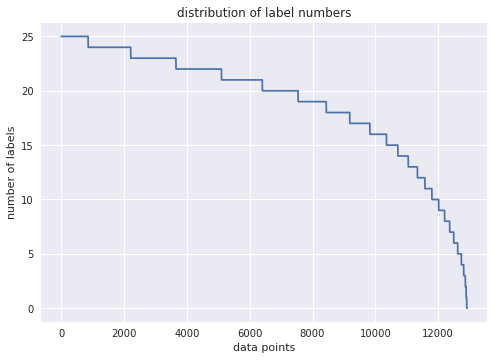

In [10]:
# number of labels for each data point
plt.plot(sorted([Y.sum() for Y in Y_tr], reverse=True))
plt.ylabel('number of labels')
plt.xlabel('data points')
plt.title('distribution of label numbers')

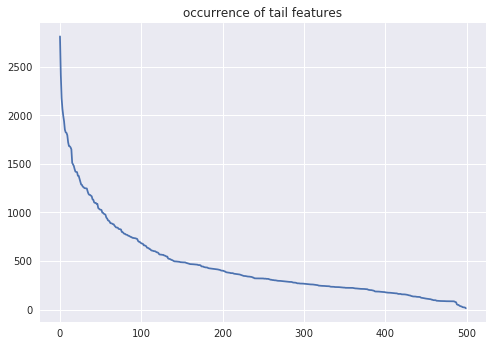

In [11]:
# usage of tail feature
plt.plot(sorted([np.count_nonzero(X_tr[:,i]) for i in range(X_tr.shape[1])], reverse=True))
plt.title('occurrence of tail features')

## Binary mapping + kNN
data set $(x,y)^d$, where $y_i=\{1, 0\}^L$

we want to map y into lower space by $$z = [M\cdot y]$$ where M is a multivariant i,i,d Gaussian matrix, and $[]$ is tkaing the sign.

Then we train binary classifiers on each bit of $z \in \{0, 1\}^{\hat L}$

For each test point, we predict its $\hat z$ and then use kNN to find the nearest k neighbors from $z=[My]$ which is all our lower degree space's mapping.

### Step 0: data preposseing
normalize features and select prominent features

In [12]:
# normalize features
X_tr = StandardScaler().fit_transform(X_tr)
X_te = StandardScaler().fit_transform(X_te)
X_te.shape

(3185, 500)

### Step 1: map to $\hat L$ space and kNN search index

We apply $$\hat L = k \log L$$ where $k$ indicates the sparsity of each label vector $y_i = \{0,1\}^L$. By default we choose k to be the 99.9% maximum sparsity to avoid extreme cases.

The data in "Eurlex" contains $L = 5000$ labels, we are trying to map it into $\hat L = 200$ space.

In [13]:
k = sorted([Y.sum() for Y in Y_tr], reverse=True)[int(num_point*0.0001)]
k

25

In [14]:
L_hat = int(math.ceil(k * math.log(Y_tr.shape[1], 2) * L_hat_ratio))
L_hat

125

In [15]:
Z_tr = util.map_2_z(Y_tr, L_hat)


### Step 2: Train Model

#### 2.1 train binary classifiers on each bit

In [16]:
def train_bit(bit):
    print "Trianning model for the {}th bit\n... ... ... \n".format(bit)
    #clf = LogisticRegression(solver='sag')
    clf = LinearSVC(dual=False)
    clf.fit(y=Z_tr[:, bit], X=X_tr)
    joblib.dump(clf, os.path.join(model_path , 'label{}.pkl'.format(bit)))
    print "{}th bit's model successfully stored in {}/label{}.pkl\n".format(bit, model_path, bit)

In [17]:
from joblib import Parallel, delayed # Multitread
#Parallel(n_jobs=num_core)(delayed(train_bit)(i) for i in range(Z_tr.shape[1]))

#### 2.2 Store the lower degree space info for kNN

We use opensource faiss library from FAIR to speedup the ANN(Approximate Nearest Neighbor) search.

When dimension and data size is relatively small, we use the brute force kNN search.

In [18]:
# faiss brute force search
nn_index = faiss.index_factory(Z_tr.shape[1], "Flat", faiss.METRIC_L2)   # build the index
nn_index.add(Z_tr.astype('float32'))

```Python
# index created by index factory
nn_index = faiss.index_factory(Z_tr.shape[1], "IVF100,Flat", faiss.METRIC_L2) # need train
nn_index.train(Z_tr.astype('float32'))
nn_index.add(Z_tr.astype('float32'))

print nn_index.nlist # number of clusters, only INF has this
nn_index.nprobe = 1 # number of clusters to search through, only INF has this, need to be validate
```

### Step 3 Prediction and Validation

In [19]:
model = BMapModel.BM_Predictor(Y_tr.shape[1], L_hat, index=nn_index, Y_tr=Y_tr, model_path=model_path)

In [20]:
# k=1 without voting
time.tic()
Y_pred = model.predict_y(X_te, 20, vote=40) # 1 nearest neighbor
time.toc()

Elapsed time is 18.124470 seconds.


In [21]:
#average_precision_score(y_true=Y_te, y_score=Y_pred, average='weighted')

In [22]:
util.precision_at_k(Y_te, Y_pred, 1)

0.60345368916797493

In [23]:
def validate_voter(voter):
    Y_pred = model.predict_y(X_te, vote=voter, weighted=True)
    return (util.precision_at_k(Y_te, Y_pred, 1))

In [24]:
p_at_k_votes = Parallel(n_jobs=num_core)\
                    (delayed(validate_voter)(voter) for voter in range(1, 100))

(0.61758241758241761, 90)

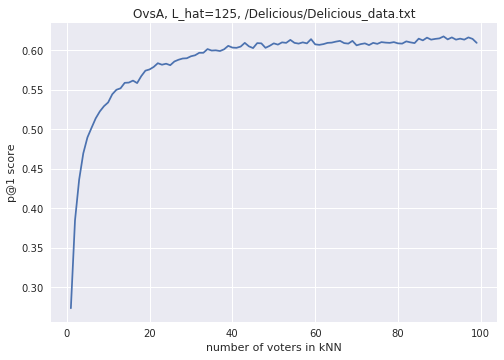

In [25]:
plt.plot(range(1,100), p_at_k_votes)
plt.xlabel('number of voters in kNN')
plt.ylabel('p@1 score')
plt.title('OvsA, L_hat={}, {}'.format(L_hat, train_filename))
top = np.argmax(p_at_k_votes)
p_at_k_votes[top], top

#### 3.2 See the model performance under no error channel
Given our predicted value is the correct "Z_te", what performance can our model achieve?

In [34]:
def validate_model(L_hat, Y_tr, Y_te, pk=1, vote=10):
    Z_tr = util.map_2_z(Y_tr, L_hat)
    z_te = util.map_2_z(Y_te, L_hat)
    # faiss brute force search
    knn_index = faiss.index_factory(Z_tr.shape[1], "Flat", faiss.METRIC_L2)   # build the index
    knn_index.add(Z_tr.astype('float32'))

    model = BMapModel.BM_Predictor(Y_tr.shape[1], L_hat, index=knn_index, Y_tr=Y_tr)

    y_pred_fake = model.vote_y(z_te, vote=vote, weighted=False)
    return util.precision_at_k(Y_te, y_pred_fake, pk)

In [35]:
pk=1;vote=40
L_hat_free_score = Parallel(n_jobs=num_core)\
                    (delayed(validate_model)(L_hat, Y_tr, Y_te, pk, vote) for L_hat in range(1, 120))

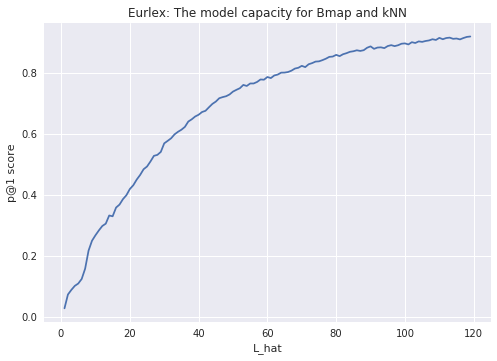

In [36]:
plt.plot(range(1,120), L_hat_free_score)
plt.xlabel('L_hat')
plt.ylabel('p@1 score')
plt.title('Eurlex: The model capacity for Bmap and kNN')

#### 3.3 optimize hyperparameter
use  k fold cross validation to optimize over 

In [61]:
# validate the result with different L_hat under the same model
def validate(L_hat, pk=1, vote=20): # simple forkable parallel for loop body
    from util import map_2_z
    from util import precision_at_k
    #k_fold = KFold(n_splits=fold)
    #print "L_hat is now {}\n".format(L_hat)
    p_sum = 0
   # for train_index, test_index in k_fold.split(X_tr):
    x_train = X_tr
    y_train = Y_tr
    x_test = X_te
    y_test = Y_te

    # map and create kNN index
    z_train = map_2_z(y_train, L_hat)
    # faiss brute force search
    knn_index = faiss.index_factory(z_train.shape[1], "Flat", faiss.METRIC_L2)   # build the index
    knn_index.add(z_train.astype('float32'))

    # construct model
    model = BMapModel.BM_Predictor(Y_tr.shape[1], L_hat, index=knn_index, Y_tr=y_train)
    model.load_clf(model_path)
    #predict and calculate p@k score
    y_pred = model.predict_y(x_test, vote=vote, weighted=True)
    # precision@pk
    #p_sum += precision_at_k(y_test, y_pred, k=pk)
    return precision_at_k(y_test, y_pred, k=pk)


In [62]:
# Optimize L_hat's value on the metric precision@k
pk=1
vote=40
L_hat_range = range(1, 200)

In [63]:
L_hat_score = Parallel(n_jobs=num_core)(delayed(validate)(L_hat, pk, vote) for L_hat in L_hat_range)

KeyboardInterrupt: 

In [ ]:
line_up, = plt.plot(range(1,200), L_hat_free_score, label='Model Capacity')
line_down, = plt.plot(range(1,200), L_hat_score, label='OvsA performance')
plt.legend(handles=[line_up, line_down])
plt.xlabel('L_hat')
plt.ylabel('precision@{}'.format(pk))
plt.title('Delicious validation on L_hat')

### 3.4 Bit Flip Probability
the classifiers predict $\hat z$ can be viewed as transmiting z from a BSC channel with some bit flip probability, this is actually representing the prediction accuracy.

In [53]:
L_hat, X_te.shape[0]

(204, 3809)

In [54]:
def validate_channel(X_te, Y_te):
    z_te = util.map_2_z(Y_te, L_hat)
    # use the classifers to predict z_hat
    model = BMapModel.BM_Predictor(Y_tr.shape[1], L_hat, model_path=model_path)
    z_pred = model.predict_z(X_te)
    
    hamming = []
    for i in range(z_te.shape[0]):
        hamming.append((z_pred[i]!=z_te[i]).sum())
    return np.array(hamming) / float(z_te.shape[1])

In [55]:
test_error = validate_channel(X_te, Y_te)

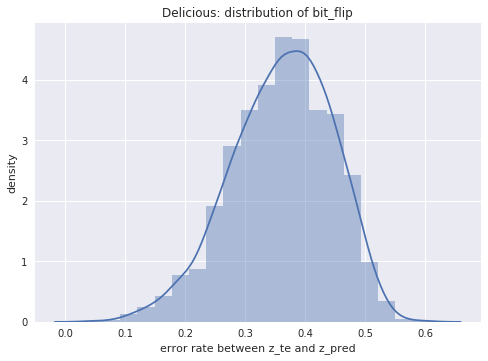

In [56]:
sns.distplot(test_error, bins=20)
plt.xlabel('error rate between z_te and z_pred')
plt.ylabel('density')
plt.title('Delicious: distribution of bit_flip')

In [57]:
test_error.mean()

0.3612960017296496

In [58]:
training_error = validate_channel(X_tr, Y_tr)

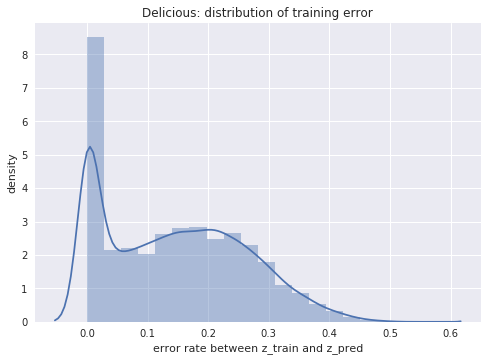

In [59]:
sns.distplot(training_error, bins=20)
plt.xlabel('error rate between z_train and z_pred')
plt.ylabel('density')
plt.title('Delicious: distribution of training error')

In [60]:
training_error.mean()

0.14555817178534969

### 3.5 Train and test model directly on the X and Y 

In [1]:
model_dir_mirror = model_dir+"_origin"
model_path_mirror = model_dir_mirror+path

NameError: name 'model_dir' is not defined